In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Data Pre-process

In [1]:
import os 
import pandas as pd

file_path = "/kaggle/input/nlp-getting-started"
train_path = os.path.join(file_path, "train.csv")
train_pd = pd.read_csv(train_path)
test_path = os.path.join(file_path, "test.csv")
test_pd = pd.read_csv(test_path)
# print the shape 
print(f"train shape: {train_pd.shape}, test shape: {test_pd.shape}")

train shape: (7613, 5), test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: ylabel='Frequency'>

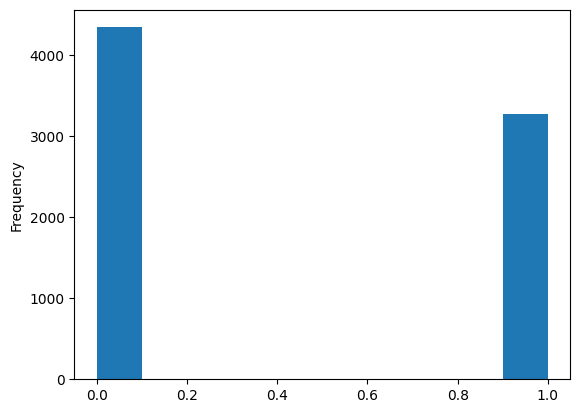

In [2]:
from IPython.display import display

display(train_pd.head())
# plot the distribution of the target in train set
display(train_pd["target"].plot.hist())

In [3]:
# add extra column to train and test to calculate the length 
train_pd["len"] = train_pd['text'].apply(lambda x: len(x))
test_pd["len"] = test_pd['text'].apply(lambda x: len(x))

0     69
1     38
2    133
3     65
Name: len, dtype: int64

<Axes: >

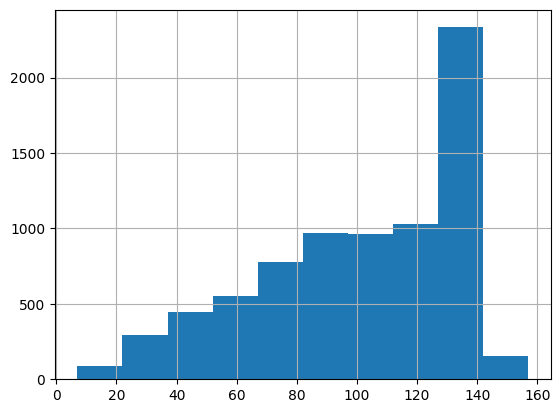

In [4]:
display(train_pd["len"][:4])
display(train_pd['len'].hist())

In [5]:
# the maximum length of the text
print(f"Max length of the text in the train: {train_pd['len'].max()}")
print(f"Max length of the text in the test: {test_pd['len'].max()}")

Max length of the text in the train: 157
Max length of the text in the test: 151


In [6]:
# process the data 
X = train_pd['text']
y = train_pd['target']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (6090,), X_test shape: (1523,)


# Distilled Bert

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
from transformers import DistilBertTokenizer, DistilBertModel

# load model and tokenizer
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
# add drop out to the model
# drop_out = 0.2

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [14]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# generate embeddings
def get_embeddings(sentences, model, tokenizer, batch_size=64, max_length=200):
    list_embeddings = []
    loader = DataLoader(sentences, batch_size=batch_size)  
    for batch in tqdm(loader):
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    #     inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        list_embeddings.append(embeddings.cpu())
    return torch.cat(list_embeddings, dim=0)

In [15]:
X_train_embeddings = get_embeddings(X_train.tolist(), model, tokenizer, batch_size=128)

100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


In [16]:
print(X_train_embeddings[0:5])
print(X_train_embeddings.size())

tensor([[ 0.0771, -0.1125, -0.0763,  ...,  0.0773, -0.1232,  0.1156],
        [ 0.1536,  0.0230,  0.2614,  ..., -0.1182, -0.0122, -0.0688],
        [ 0.0488, -0.0772,  0.1187,  ...,  0.1586, -0.1116,  0.1562],
        [ 0.1748, -0.1002,  0.1794,  ..., -0.1655, -0.1155,  0.0162],
        [ 0.0174, -0.0439,  0.1390,  ...,  0.0294, -0.0535,  0.0708]])
torch.Size([6090, 768])


In [18]:
X_test_embeddings = get_embeddings(X_test.tolist(), model, tokenizer, batch_size=128)

100%|██████████| 12/12 [00:03<00:00,  3.34it/s]


In [19]:
print(X_test_embeddings[0:5])
print(X_test_embeddings.size())

tensor([[ 0.2162, -0.0371,  0.0762,  ..., -0.1793, -0.1276,  0.0007],
        [ 0.1839,  0.1818,  0.3484,  ..., -0.0265, -0.0922,  0.2073],
        [ 0.0760, -0.1890,  0.3928,  ..., -0.1751, -0.0485,  0.1743],
        [ 0.1169, -0.0734,  0.2177,  ...,  0.1135, -0.0036, -0.0947],
        [-0.2102,  0.1161,  0.0361,  ..., -0.2805, -0.1425, -0.0619]])
torch.Size([1523, 768])


In [20]:
# check our model 
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.39.3",
  "vocab_size": 30522
}

In [31]:
type(torch.tensor(y_train.values))

torch.Tensor

In [46]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings.cpu() # ensure encodings are on CPU
        self.labels = labels.cpu() # ensure labels are on CPU

    def __getitem__(self, index):
        item = {key: val[index].to(device) for key, val in self.encodings.items()}
        item['labels'] = self.labels[index].to(device)
        return item

    def __len__(self):
        return len(self.labels)

# Create instances of MyDataset
train_dataset = MyDataset(X_train_embeddings, torch.tensor(y_train.values))
test_dataset = MyDataset(X_test_embeddings, torch.tensor(y_test.values))

In [47]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(output_dir = "/kaggle/working/",
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  num_train_epochs=5)

trainer= Trainer(model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=train_dataset)

trainer.train()

AttributeError: 'Tensor' object has no attribute 'items'

In [ ]:
# evaluate the model



# test the model
# load the test data
X_val = test_pd['text']

X_val_tokenized = tokenizer(X_val.to_list(), padding=True, truncation=True, return_tensors="pt",max_length = 200)


# create the dataset


# make the prediction
with torch.no_grad():
    X_val_encoded = model(**X_val_tokenized.to("cuda"))

# write the prediction to a csv file
# get the prediction
y_val = torch.argmax(X_val_encoded.logits, dim=1).cpu().numpy()




In [ ]:
# create the submission file
from sklearn.metrics import f1_score
submission = pd.DataFrame()
submission['id'] = test_pd['id']
submission['target'] = y_val
submission.to_csv("submission.csv", index=False)

# 
with open("submission_example.csv", "r") as f:
    # check the accuracy
    submission_example = pd.read_csv(f)

    # check the accuracy
accuracy = (submission_example['target'] == submission['target']).mean()
print(f"Accuracy: {accuracy}")
# check the f1 score
f1 = f1_score(submission_example['target'], submission['target'])
print(f"F1 Score: {f1}")


